# Modeling BLS signal from single magnetic layer
This example shows how SpinWaveToolkit (SWT) can be used to calculate the expected BLS signal of a single magnetic layer. 

We start by impoting the modules we need and by defining the parameters of the system and model.

In [1]:
# Import modules
import numpy as np
import SpinWaveToolkit as SWT
from matplotlib import pyplot as plt

In [2]:
# Define parameters
Bext = 50e-3         # External field [T]
theta = np.pi / 2    # Out-of-plane angle (fixed)
d_layer = 30e-9      # Magnetic layer thickness [m]
material = SWT.NiFe  # Material (from built-ins)
Nf_common = 101       # Number of frequency points for Bloch function

# Define the Kx,Ky grid limits and resolution.
Nk = 100             # resolution in Kx and Ky
k_max = 15e6         # maximum k (as in original kxi range)
NA = 0.75            # Numerical Aperture (NA) for the lens

# Create a regular Kx,Ky grid
kx_grid = np.linspace(-k_max, k_max, Nk)
ky_grid = np.linspace(-k_max, k_max, Nk)
kx_grid[np.abs(kx_grid) < 1e-6] = 1e-6  # avoid division by zero at k=0
kx_grid[np.abs(kx_grid) < 1e-6] = 1e-6
KX, KY = np.meshgrid(kx_grid, ky_grid, indexing='ij')
K = np.sqrt(KX**2 + KY**2)
PHI = np.arctan2(KY, KX)

Now we calculate the electric field incident on the magnetic layer using the `ObjectiveLens` class, get the Bloch functions in 3D and compute the BLS signal using the `getBLSsignal` function.

In [5]:
print("Preparing focal field...")
objective = SWT.bls.ObjectiveLens(NA=NA, wavelength=532e-9, f0=10, f=1e-3)
x, y, Ex, Ey, Ez = objective.getFocalField(z=0, rho_max=10e-6, N=400)
E = [Ex, Ey, Ez]
Exy = [x, y]

# Preallocate the output array for the Bloch function amplitudes.
# The result will be complex amplitudes defined on a common frequency axis.
# Shape: (Nf_common, Nk, Nk)
Bloch2D = np.zeros((Nf_common, Nk, Nk), dtype=complex)

# We will also store the common frequency axis.
w_common = np.linspace(4, 27, Nf_common)*2e9*np.pi  # (rad/s)

print("Preparing Bloch functions in 3D (f,kx,ky) using Kalinikos-Slavin model...")
# Create a SingleLayer model for the current kxi and phi.
# Note: We pass kxi and phi as arbitrary values for now.
model = SWT.SingleLayer(Bext=Bext, kxi=(0,), theta=theta,
                        phi=0, d=d_layer, material=material)
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Set correct kxi and phi for the current grid point.
        model.kxi = np.array((K[i, j],))  # must be an array
        model.phi = PHI[i, j]
        # Compute the Bloch functions for n=0,1; higher n are outside `w_common`
        # The returned w has shape (Nf_common,) and bf has shape (Nf_common, 1),
        # since we are passing kxi as length-1 array.
        w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
        w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, 0], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf1[:, 0], left=0, right=0)

        # Sum Bloch functions for n=0,1
        Bloch2D[:, i, j] = bf0_interp + bf1_interp

Bloch3 = [Bloch2D, np.zeros((Nf_common, Nk, Nk), dtype=complex), Bloch2D*1j]

print("Computing BLS signal from Kalinikos-Slavin model...")
# Compute the BLS signal using the Bloch functions and the electric field.
Ex, Ey = SWT.bls.getBLSsignal(
    # The Bloch functions and related axis vectors
    SweepBloch=w_common, KxKyBloch=[kx_grid, ky_grid], Bloch=np.array(Bloch3),
    Exy=Exy, E=E,  # the incoming electric field from the objective
    Nq=50,  # number of points to use in the k-space integration
    # dielectric functions of the multilayer system: air, NiFe, substrate
    DF=[1, -8.1653 + 1j*15.348, 17.237 + 1j*0.43004],
    PM=[1,1,1],  # same for permeabilities (response of NiFe is included in the Bloch functions)
    d=[d_layer], # thicknesses of the inner layers, here just NiFe
    NA=NA, # numerical aperture of the collecting objective (here the same as focusing)
    source_layer_index=1,  # layer with the magnetic film
    output_layer_index=0,  # layer in which we observe the scattered light (air)
    # other parameters of the optical setup
    wavelength=532e-9, collectionSpot=0.5e-6, focalLength=1e-3
)[:2]
print("Done")

Preparing focal field...
Preparing Bloch functions in 3D (f,kx,ky) using Kalinikos-Slavin model...
Computing BLS signal from Kalinikos-Slavin model...
Done


Finally, we plot the resulting BLS signal.

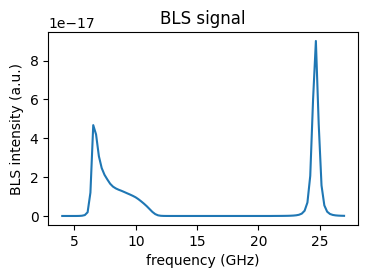

In [6]:
# Plot the BLS signal
plt.figure(figsize=(4, 2.5))
plt.plot(w_common/2/np.pi/1e9, np.abs(Ey*np.conj(Ey)), label='Kalinikos-Slavin model')
plt.xlabel('frequency (GHz)')
plt.ylabel('BLS intensity (a.u.)')
plt.title('BLS signal')
plt.show()

*Note: Sometimes the relative amplitude of PSSW peaks does not match the experiment, since it may depend on a vast number of parameters. If that is the case, calculate the BLS signal separately and normalize to each respective peak.*

### Tip on speeding things up
Calculations of 2D dispersion and Bloch functions using some dispersion models can be greatly accelerated when we pass the `K` and `PHI` as flattened arrays. What happens is that if the model does not iterate over wavenumbers, it can calculate the dispersion for the whole 1d array of wavenumbers at once (therefore there is no need for the double for loop). If we supply a parameter of the same shape, it may be broadcasted together. The only thing we need to do then is to reshape the acquired data back to our square reciprocal space grid.

Unfortunately, this is currently supported only by the `SingleLayer` class at the moment. Maybe we will try to implement it in a limited form also in other classes.

For example this code from above

In [7]:
# ...
# Create a SingleLayer model for the current kxi and phi.
# Note: We pass kxi and phi as arbitrary values for now.
model = SWT.SingleLayer(Bext=Bext, kxi=(0,), theta=theta,
                        phi=0, d=d_layer, material=material)
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Set correct kxi and phi for the current grid point.
        model.kxi = np.array((K[i, j],))  # must be an array
        model.phi = PHI[i, j]
        # Compute the Bloch functions for n=0,1; higher n are outside `w_common`
        # The returned w has shape (Nf_common,) and bf has shape (Nf_common, 1),
        # since we are passing kxi as length-1 array.
        w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
        w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, 0], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf1[:, 0], left=0, right=0)

        # Sum Bloch functions for n=0,1
        Bloch2D[:, i, j] = bf0_interp + bf1_interp

Bloch3 = [Bloch2D, np.zeros((Nf_common, Nk, Nk), dtype=complex), Bloch2D*1j]
# ...

can be replaced by this

In [8]:
# ...
# Create a SingleLayer model for the current kxi and phi.
# Note: We pass kxi and phi as flattened arrays of same shape.
model = SWT.SingleLayer(Bext=Bext, kxi=K.flatten(), theta=theta,
                        phi=PHI.flatten(), d=d_layer, material=material)
# Compute the Bloch functions for n=0,1.
# The returned w has shape (Nf_common,) and bf has shape (Nf_common, len(kxi))
w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
# reshape Bloch functions to match the Kx,Ky grid shape
bf0 = bf0.reshape((Nf_common, Nk, Nk))
bf1 = bf1.reshape((Nf_common, Nk, Nk))
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, i, j], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf1[:, i, j], left=0, right=0)

        # Sum Bloch functions for n=0,1,2
        Bloch2D[:, i, j] = bf0_interp + bf1_interp

Bloch3 = [Bloch2D, np.zeros((Nf_common, Nk, Nk), dtype=complex), Bloch2D*1j]
# ...

which is much faster in most cases. More specifically, here it is about 100× faster, but is depends greatly on number of points in the grid (more convenient with large number of points).

*(Note that the double for loop was not totally eliminated, since we need to perform the interpolation of the Bloch functions at each point.)*